<a href="https://colab.research.google.com/github/KimRRRich/PytorchExercise/blob/main/02_pytorch_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=518)

print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y features:\n{y[:5]}")

First 5 X features:
[[ 0.04287625 -0.78395371]
 [-0.9675859  -0.20787193]
 [-0.21378363 -0.72637976]
 [-0.28280413  0.74257057]
 [-0.36706005 -0.91573326]]
First 5 y features:
[1 0 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                       "X2": X[:,1],
                       "label":y
                        })
circles.head(10)

,X1,X2,label
0,0.042876,-0.783954,1
1,-0.967586,-0.207872,0
2,-0.213784,-0.726380,1
3,-0.282804,0.742571,1
4,-0.367060,-0.915733,0
5,0.501732,-0.940620,0
6,-0.719812,0.685705,0
7,-0.680459,-0.436218,1
8,-0.067329,1.011916,0
9,-0.540578,-0.853906,0


In [4]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


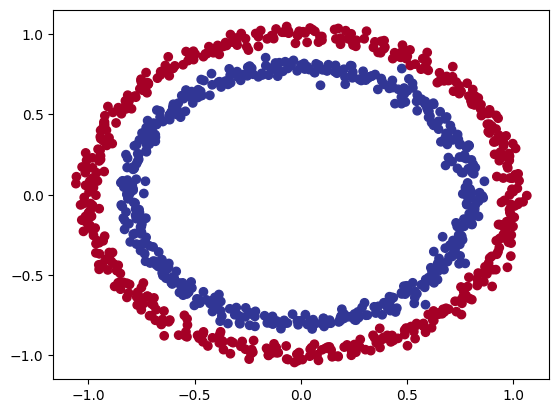

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [24]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
# Make predictions with the model
X_test = torch.tensor(X_test,dtype=torch.float32)
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: (200,)

First 10 predictions:
tensor([[0.5857],
        [0.5615],
        [0.5207],
        [0.6267],
        [0.6684],
        [0.5596],
        [0.7212],
        [0.7219],
        [0.5235],
        [0.5465]], grad_fn=<SliceBackward0>)

First 10 test labels:
[1 1 0 0 0 0 1 1 0 1]


In [16]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [17]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [18]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test)[:5]
y_logits

tensor([[0.5857],
        [0.5615],
        [0.5207],
        [0.6267],
        [0.6684]], grad_fn=<SliceBackward0>)

Sigmoid 激活函数是一种常用的激活函数，特别是在神经网络中。它的主要作用是将输入值（通常是神经元的加权和）压缩到 0 到 1 之间。这个特性使得它在二分类问题中非常有用，因为可以将输出解释为概率值。

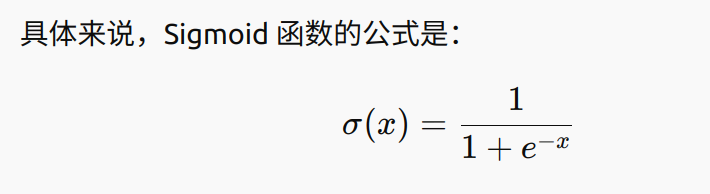

其中
𝑒
e 是自然对数的底数。Sigmoid 函数的图像呈“S”形，随着输入的增加，输出逐渐趋近于 1，随着输入的减少，输出趋近于 0。这种特性使得它可以有效地处理非线性问题。

不过，Sigmoid 也有一些缺点，比如在输入值很大或很小时，梯度会变得非常小（梯度消失问题），这会导致训练速度变慢或陷入局部最优。因此，在深度学习中，其他激活函数（如 ReLU）也得到了广泛使用。


In [19]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6424],
        [0.6368],
        [0.6273],
        [0.6517],
        [0.6612]], grad_fn=<SigmoidBackward0>)

In [20]:
y_preds = torch.round(y_pred_probs)
y_preds.squeeze()

tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [39]:
torch.manual_seed(518)

epoches = 100

for epoch in range(epoches):
  model_0.train()
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    test_pred = torch.round(torch.sigmoid(test_logits))
    # print(test_logits[:5])
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
    if epoch % 10 == 0:
      print(f"Epoch:{epoch} | Loss:{test_loss:.5f} | Acc:{test_acc:.2f}%")

Epoch:0 | Loss:0.69342 | Acc:54.00%
Epoch:10 | Loss:0.69342 | Acc:54.00%
Epoch:20 | Loss:0.69342 | Acc:54.00%
Epoch:30 | Loss:0.69342 | Acc:53.50%
Epoch:40 | Loss:0.69342 | Acc:53.50%
Epoch:50 | Loss:0.69342 | Acc:53.50%
Epoch:60 | Loss:0.69342 | Acc:53.50%
Epoch:70 | Loss:0.69342 | Acc:53.50%
Epoch:80 | Loss:0.69342 | Acc:53.50%
Epoch:90 | Loss:0.69342 | Acc:53.00%


<ipython-input-39-f422aa14f7fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-39-f422aa14f7fc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-39-f422aa14f7fc>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-39-f422aa14f7fc>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

In [40]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

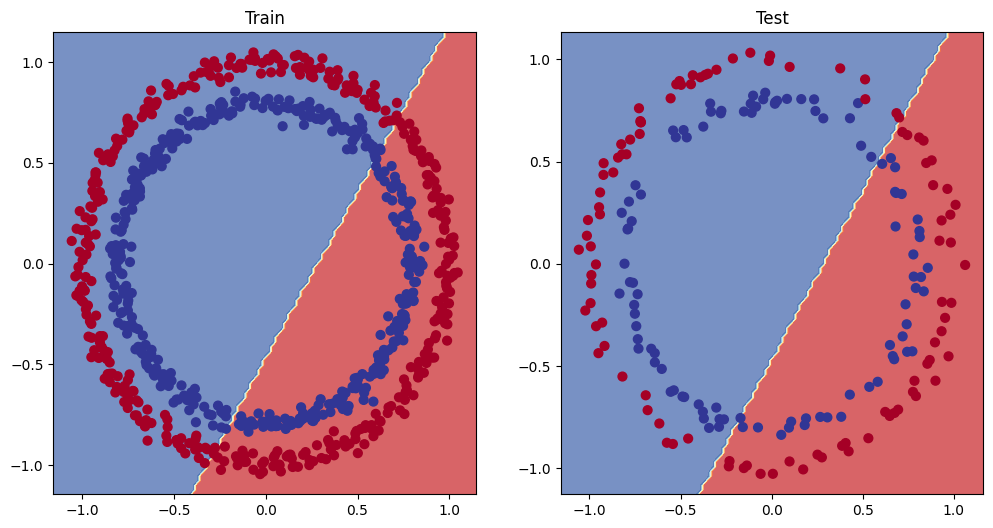

In [41]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [61]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1()
print(model_1)
print(X_train[:5])

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)
tensor([[ 0.7958,  0.0354],
        [ 0.1150, -0.9570],
        [ 0.7618,  0.0052],
        [ 0.6680, -0.4304],
        [-0.8224, -0.1076]])


In [62]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [115]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  # print(y_logits[:5])
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
      print(f"Epoch:{epoch} | Loss:{test_loss:5f} | ACC:{test_acc:2f}%")

Epoch:0 | Loss:647.753601 | ACC:99.500000%
Epoch:100 | Loss:647.753601 | ACC:99.500000%
Epoch:200 | Loss:647.753601 | ACC:99.500000%
Epoch:300 | Loss:647.753601 | ACC:99.500000%
Epoch:400 | Loss:647.753601 | ACC:99.500000%
Epoch:500 | Loss:647.753601 | ACC:99.500000%
Epoch:600 | Loss:647.753601 | ACC:99.500000%
Epoch:700 | Loss:647.753601 | ACC:99.500000%
Epoch:800 | Loss:647.753601 | ACC:99.500000%
Epoch:900 | Loss:647.753601 | ACC:99.500000%


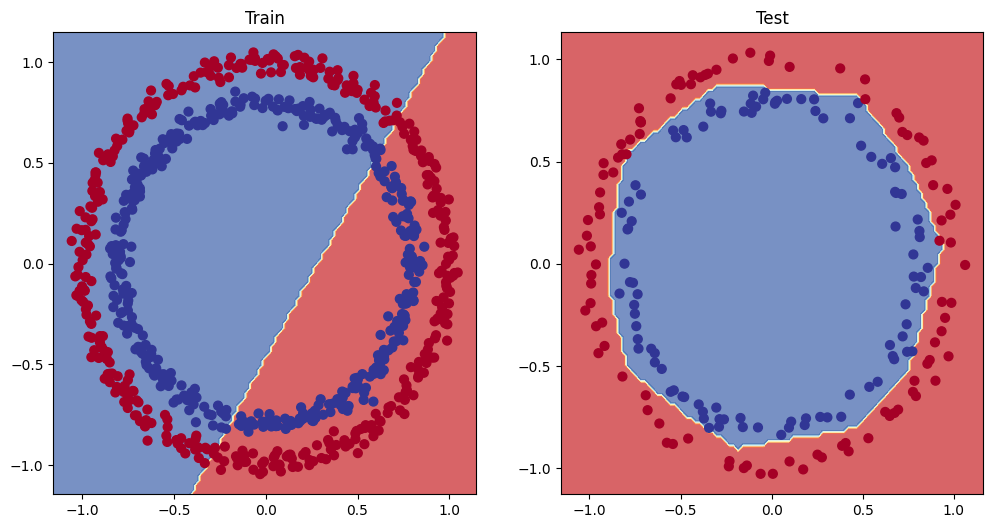

In [66]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


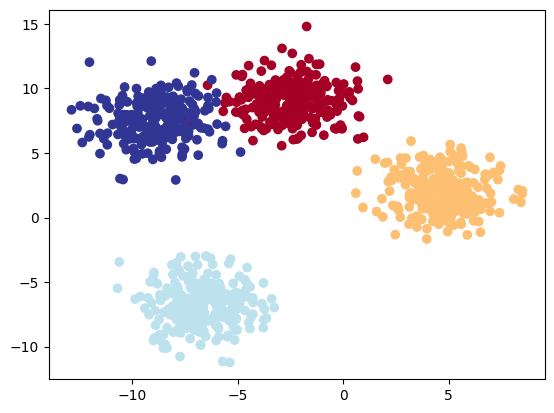

In [138]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# torch.manual_seed(42)
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)


# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);
# ax.set_xlabel('Feature 1')
# ax.set_ylabel('Feature 2')
# ax.set_zlabel('Feature 3')
plt.show()

In [141]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)


model_2 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [142]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [126]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_2(X_blob_train)[:5]

tensor([[ 1.9582, -1.7906, -0.3523, -0.4815],
        [-1.6822,  1.9877, -0.5779,  0.9026],
        [ 1.7593, -1.2932, -0.1352, -0.8134],
        [ 1.6794, -0.9008,  0.1038, -1.2164],
        [ 2.1393, -1.6362, -0.0711, -1.0299]], grad_fn=<SliceBackward0>)

In [143]:
# How many elements in a single prediction sample?
model_2(X_blob_train)[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [144]:
# Make prediction logits with model
y_logits = model_2(X_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
print(torch.argmax(y_pred_probs[0]))

tensor([[ 0.2353,  0.7279,  0.6180, -0.4412],
        [ 0.0355,  0.3471,  0.2405, -0.1154],
        [ 0.0744,  0.4955, -0.0985, -0.1083],
        [ 0.1816,  0.5441,  0.2874, -0.3003],
        [ 0.2981,  0.8786,  0.7174, -0.5742]], grad_fn=<SliceBackward0>)
tensor([[0.2169, 0.3549, 0.3180, 0.1103],
        [0.2246, 0.3067, 0.2757, 0.1931],
        [0.2382, 0.3630, 0.2004, 0.1984],
        [0.2400, 0.3449, 0.2668, 0.1482],
        [0.2116, 0.3781, 0.3218, 0.0884]], grad_fn=<SliceBackward0>)
tensor(1)


In [147]:
torch.manual_seed(518)

epochs = 1000

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)

  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_logits = model_2(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)

    test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 10 == 0:
      print(f"Epoch:{epoch} | Loss:{test_loss:5f} | ACC:{test_acc:2f}%")

Epoch:0 | Loss:0.116588 | ACC:99.500000%
Epoch:10 | Loss:0.109408 | ACC:99.500000%
Epoch:20 | Loss:0.103119 | ACC:99.500000%
Epoch:30 | Loss:0.097572 | ACC:99.500000%
Epoch:40 | Loss:0.092649 | ACC:99.500000%
Epoch:50 | Loss:0.088255 | ACC:99.500000%
Epoch:60 | Loss:0.084312 | ACC:99.500000%
Epoch:70 | Loss:0.080766 | ACC:99.500000%
Epoch:80 | Loss:0.077554 | ACC:99.500000%
Epoch:90 | Loss:0.074628 | ACC:99.500000%
Epoch:100 | Loss:0.071958 | ACC:99.500000%
Epoch:110 | Loss:0.069513 | ACC:99.500000%
Epoch:120 | Loss:0.067282 | ACC:99.500000%
Epoch:130 | Loss:0.065220 | ACC:99.500000%
Epoch:140 | Loss:0.063309 | ACC:99.500000%
Epoch:150 | Loss:0.061543 | ACC:99.500000%
Epoch:160 | Loss:0.059899 | ACC:99.500000%
Epoch:170 | Loss:0.058358 | ACC:99.500000%
Epoch:180 | Loss:0.056927 | ACC:99.500000%
Epoch:190 | Loss:0.055589 | ACC:99.500000%
Epoch:200 | Loss:0.054326 | ACC:99.500000%
Epoch:210 | Loss:0.053160 | ACC:99.500000%
Epoch:220 | Loss:0.052047 | ACC:99.500000%
Epoch:230 | Loss:0.051

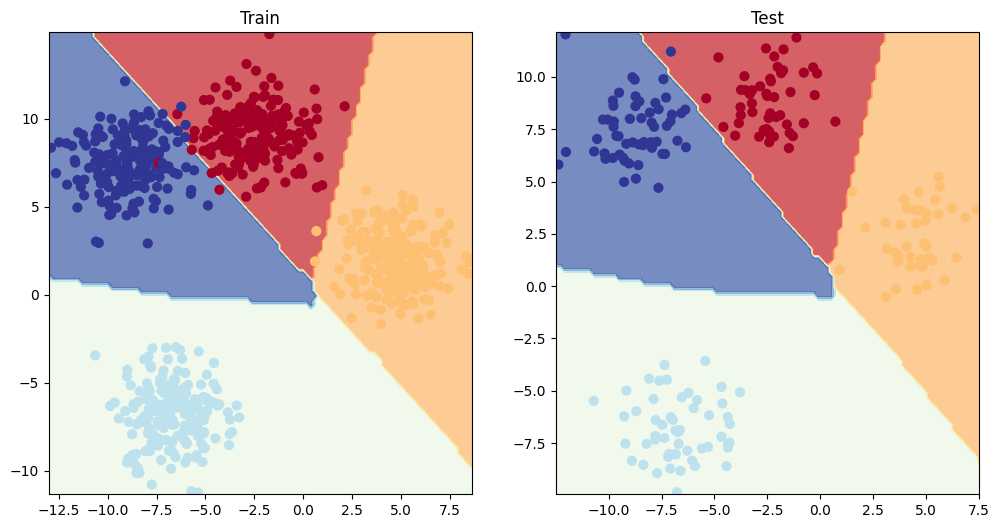

In [146]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)